In [1]:
from time import time
import pandas as pd
import numpy as np
from PIL import Image
import keras.layers.advanced_activations
import scipy
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
%matplotlib inline
from sklearn import manifold, datasets,cluster
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

# As for classification
### the best result now comes from 5-channel input with 3-hidden variables

In [3]:
Image_RGB = np.empty((len(Image),64,64,5))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][4],Image[i][3],Image[i][2],Image[i][1],Image[i][0]),axis=-1)


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*5):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [4]:
show_Image_RGB = (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))*2 - np.ones_like(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.std((Image_RGB))

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB
index = [i for i in range(len(data))]
random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 5)
train_label.shape: (14142, 3)


In [6]:
batch_size =100
latent_dim = 3
nb_epoch = 50
epsilon_std = 2.0
intermediate_dim =512
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,5))

conv_1 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)


#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


conv_6 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(5, (3, 3), activation='tanh', padding='same')(upsample_10)


EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [7]:
vae.load_weights("15epoch_3hidden_newone0808.h5")
#vae.save_weights("15epoch_3hidden_newone0808.h5")

In [8]:
vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space
x_vis = vis.predict(train_data[8500:14000], batch_size=batch_size)

In [9]:
n_points = np.shape(x_vis)[0]
n_neighbors = 10
n_components = 1
isomap = manifold.Isomap(n_neighbors, n_components)
hid_pred = vis.predict(train_data, batch_size=batch_size)
Y_pred = isomap.fit_transform(hid_pred)

In [14]:
Y_pred =-Y_pred

In [15]:
count_ = 0
for i in range(len(x_vis)):
    if Y_pred[8500:14000][i]> -0.435:
        count_+=1
print("predict abs with threshold above:\n",count_/len(x_vis))
print(" %.4g" % float(np.sum(Class[Class==1])/14142*100),"%")

predict abs with threshold above:
 0.6889090909090909
 67.85 %


In [16]:
count_gala = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] >-0.435):
        if Class[i]==1:
            count_gala+=1
print(count_gala/np.sum(Class[Class==1]))
print(np.sum(Class[Class==1])-count_gala)

0.909962484368
864


In [17]:
count_star = 0
for i in range(len(hid_pred)):
    if (Y_pred[i] <-0.435):
        if Class[i]==0:
            count_star+=1
print(count_star/(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2))
print((len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)

0.7998327293
718.0


In [18]:
print("total accuracy is:",1-((np.sum(Class[Class==1])-count_gala)+(len(hid_pred) - np.sum(Class[Class==1]) -np.sum(Class[Class==2])/2)-count_star)/len(Y_pred))

total accuracy is: 0.888134634422


# ROC curve

In [19]:
thr_min = -5
thr_max = 5
test_accuracy = 0.001
test_range = int((thr_max - thr_min)/test_accuracy)
print(test_range)

10000


In [20]:
FP = []
TP = []
TN = []
FN = []
TA = np.ones((Y_pred.shape[0],))
TA[Class ==0 ] = 0
TA[Class ==2 ] = 0

for i in range(test_range):
    FP_temp = np.zeros((Y_pred.shape[0]))
    TP_temp = np.zeros((Y_pred.shape[0]))
    TN_temp = np.zeros((Y_pred.shape[0]))
    FN_temp = np.zeros((Y_pred.shape[0]))
    LA = np.zeros((Y_pred.shape[0],))
    thr_now = thr_min+ i*test_accuracy
    LA[Y_pred[:,0] > thr_now] = 1
    for j in range(Y_pred.shape[0]):
        if LA[j]==0:
            if TA[j]==1:
                FN_temp[j] = 1
            else:
                TN_temp[j] = 1
        else:
            if TA[j] == 1:
                TP_temp[j] = 1
            else:
                FP_temp[j] = 1
    FP.append(FP_temp)
    TP.append(TP_temp)
    TN.append(TN_temp)
    FN.append(FN_temp)

In [21]:
TPR = np.zeros((test_range,))
FPR = np.zeros((test_range,))
TPR = np.sum(TP,axis=-1)/(np.sum(TP,axis=-1)+np.sum(FN,axis=-1))
FPR = np.sum(FP,axis=-1)/(np.sum(FP,axis=-1)+np.sum(TN,axis=-1))

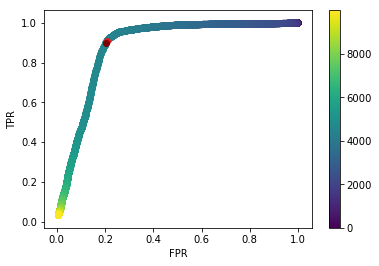

In [23]:
plt.scatter(FPR,TPR,c=[i for i in range(test_range)])

plt.colorbar()
plt.scatter(FPR[int((-0.435-thr_min)/test_accuracy-1)],TPR[int((-0.435-thr_min)/test_accuracy-1)],c=0,cmap='Set1')
#chose from priori knowledge, Red
plt.scatter(FPR[np.argmin((TPR-1)**2 + FPR**2)],TPR[np.argmin((TPR-1)**2 + FPR**2)],c=0,cmap='OrRd_r')
plt.xlabel('FPR')
plt.ylabel('TPR')
#argmax, OrRed

# The segmentation task
### Best result now comes when I use only the 'i' channel of the 5 channels, and use more hidden variables in VAE

In [3]:
Image_RGB = np.empty((len(Image),64,64))#(14142,64,64,1) one channel images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = Image[i][3]


for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*1):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=np.mean(Image_RGB[i-1])

815


In [4]:
#Image_RGB =(1- ( (Image_RGB - np.min(Image_RGB))/(np.max(Image_RGB) - np.min(Image_RGB))))*2 - 1

Image_RGB /= np.max(Image_RGB)
Image_RGB -= np.mean(Image_RGB)
Image_RGB = -Image_RGB

In [5]:
label = np_utils.to_categorical(Class, 3)
data = Image_RGB.reshape(-1,64,64,1)
index = [i for i in range(len(data))]
#random.shuffle(index)
train_data = data[index]
train_label = label[index]
Class = Class[index]
Redshift = Redshift[index]
#show_Image_RGB = show_Image_RGB[index]
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)

train_data.shape: (14142, 64, 64, 1)
train_label.shape: (14142, 3)


In [6]:
batch_size =100
latent_dim = 30
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
#intermediate_dim_2 = 300
original_dim = 64*64

input_img = Input(shape=(64,64,1))

conv_1 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
#maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

#conv_5 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(maxpool_4)
#maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(conv_4)
h_1 = Dense(intermediate_dim_1, activation='relu')(visual)
#h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='tanh')(z)
h_5 = Dense(80*8*8,activation='relu')(h_4)
h_6 = Reshape((8,8,80))(h_5)


#conv_6 = Conv2D(80, (3, 3), activation='tanh', padding='same',kernel_initializer='normal')(h_6)
#upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
#upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(conv_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)



In [7]:
vae.load_weights("Correct_normalization_great_segmentation0807.h5")

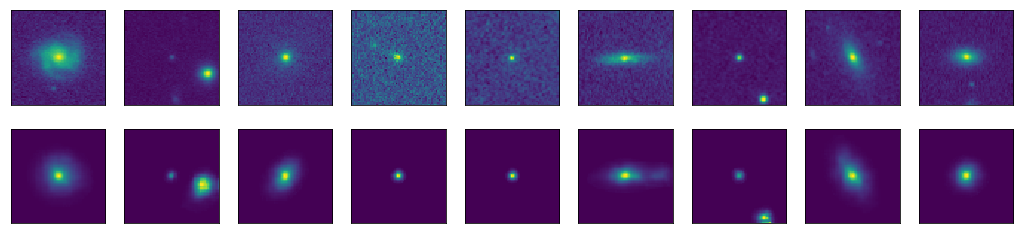

In [8]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = vae.predict(train_data[8000:9500],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9500][i][:,:,0]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i][:,:,0]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
#model_pool_4 = Model(input_img,maxpool_4)
#model_conv_5 = Model(input_img,conv_5)
#model_pool_5 = Model(input_img,maxpool_5)
#model_conv_6 = Model(input_img,conv_6)
#model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
#model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
#lyr.append(model_pool_4)
#lyr.append(model_conv_5)
#lyr.append(model_pool_5)
#lyr.append(model_conv_6)
#lyr.append(model_up_6)
lyr.append(model_conv_7)
#lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)
lyr.append(vae)

In [19]:
import scipy
RANGE=40
total_hyp = []
for No_ in range(RANGE):
    hypercolumns = []
    hypercolumns_class = []
    for i in [0,1,2,14,14,14,14,14,14,14]:
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[10200:10300],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    total_hyp.append(hypercolumns)

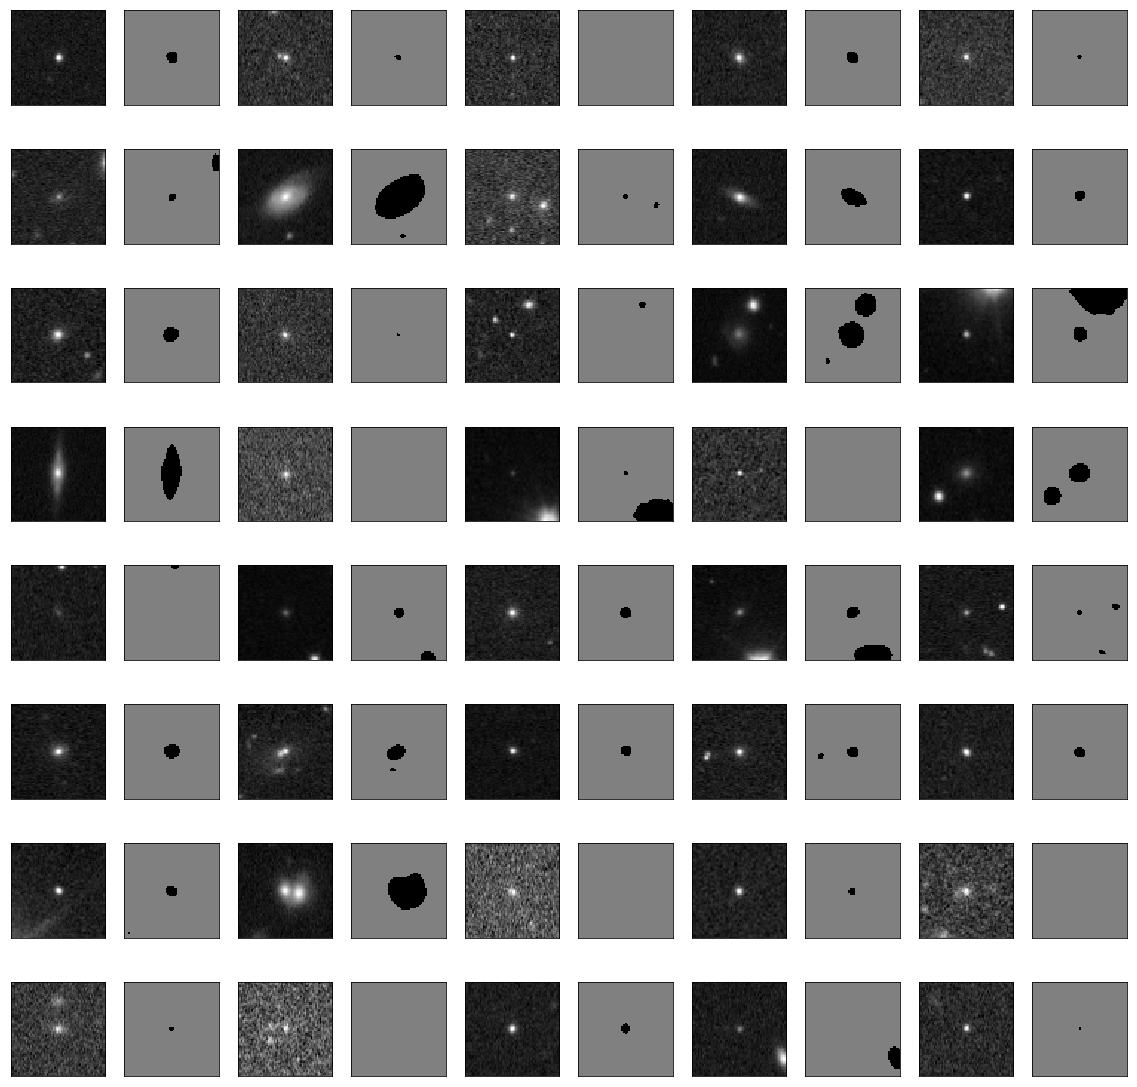

In [20]:
total_hyp = np.asarray(total_hyp)
m=total_hyp.transpose(0,2,3,1).reshape(64*64*RANGE,-1)
#db = DBSCAN(eps=0.5, min_samples=200).fit(m)
#cluster_labels = db.labels_
kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
#SC = SpectralClustering(n_clusters=2).fit(m)
cluster_labels = kmeans.fit_predict(m)
imcluster = cluster_labels
for i in range(RANGE):
    imcluster[i*64*64:(i+1)*64*64][0]=0
    imcluster[i*64*64:(i+1)*64*64][1]=1
    imcluster[i*64*64:(i+1)*64*64][2]=2

fig = plt.figure(figsize=(20, 20))

for i in range(RANGE):
    ax = plt.subplot(8,10,i*2+1)
    plt.gray()
    plt.imshow(Image_RGB[10200:10300][i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(8,10,i*2+2)
    plt.imshow(imcluster[i*64*64:(i+1)*64*64].reshape(64, 64))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()